# Basic Probabilistic Programming with Pyro

One of the interesting techniques which has become of interest lately is the use of probabilistic programming. 
If you've never heard of probabilistic programming before, you might conclude it is just programming with probabilities. That would be correct, but only part of the story. 

At its core, probabilistic programming is about finding underlying distributions which affect processes of interest. You define a process and how it works, and then allow your Probabilistic Programming Language (PPL) of choice to infer what are the likely values for factors which influence your process, and how likely they are.

This is explained best with an example, and for this example I'll be using Pyro as the PPL of choice, as well as a simple case study largely inspired [from the official Pyro tutorial](http://pyro.ai/examples/intro_part_ii.html).

## Building Our Process - A Magical Kitchen Scale

Imagine you had a kitchen scale, you put an object on it, and the scale tells you its weight. But imagine the scale is quite old, and is not very accurate. Every time you put the same object on it, it gives you a slightly different measurement. However, you observed that this scale, in some magical way errs in a way that forms a normal distribution around the true weight of the item, with a standard deviation of 0.1kg

$$\text{Observation} \sim \mathcal{N}(\text{Weight}, 0.1)$$

Let's describe this process (we'll be using PyTorch, which is what Pyro uses as its underlying tensor calculation engine). 

First, we will import our required libraries

In [1]:
import torch
import pyro
assert pyro.__version__.startswith('1.3') # I'm writing this tutorial with version
                                          # 1.3.1. 
pyro.set_rng_seed(0)

import torch.distributions as dist
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time

%matplotlib inline

import seaborn as sns

Let's define our kitchen scale, or more specifically, the process it employs to give us observations

In [2]:
def process(weight):
    
    my_dist = dist.Normal(weight, 0.1)
    observation = my_dist.sample()
    return observation

Now let's ask ourselves an easy question; 

> if we put a 0.5kg item on this scale, what are some possible values we will get back?

In [3]:
print(process(0.5))
print(process(0.5))
print(process(0.5))

tensor(0.6541)
tensor(0.4707)
tensor(0.2821)


We got back a collection of 3 values. Each time we ask our scale for an answer, we'll get a slightly different value. Sometimes the values will be very close to 0.5 (this will happen most of the time), and sometimes they will be very far. This was easy enough to implement though, nothing new in terms of programming there.

Let's try a more difficult question; 

> What is the probability of observing a value above 0.63?

We can answer that programmatically as well. We'll just generate many values, count all the values we generated, count all the values above 0.63, and find their ratio

In [4]:
from scipy.stats import norm

rough_estimate = np.sum([process(0.5) > 0.63 for i in range(1000)])/1000
print(f'rough estimate: {rough_estimate}')

reasonable_estimate = np.sum([process(0.5) > 0.63 for i in range(10000)])/10000
print(f'reasonable estimate: {reasonable_estimate}')

good_estimate = np.sum([process(0.5) > 0.63 for i in range(100000)])/100000
print(f'good estimate: {good_estimate}')

true_estimate = 1.0 - norm(0.5, 0.1).cdf(0.63)
print(f'true estimate: {true_estimate}')

rough estimate: 0.097
reasonable estimate: 0.101
good estimate: 0.09691
true estimate: 0.0968004845856103


If we run the process enough times, we'll get an estimate that is good for all intents and purposes. This took a bit more work, and some more time, but overall this workflow wasn't too hard either.

Let's try an even more difficult question; 

> I've observed a value of 0.63kg, what is the likeliest true weight of the item?

This might take you by surprise, but after a bit of thinking, you might recall my magical inaccurate-yet-well-behaved-scale reports a normal distribution around the true weight of the item, so with no further information, the most likely weight is in fact 0.63kg. 

However, this was largely easy because **we know** the distribution is normal around the true weight of the scale. What if it wasn't normal? what if it wasn't even something pre-built into Python?

Now let's try a hard question that will motivate our use of probabilistic programming?

> Let's imagine we got the following set of measurements, or observations, from our scale: 0.74kg, 0.98kg, 0.66kg, 0.75kg, 0.84kg, and 0.74kg, what is the likeliest true weight of the object?

**The true weight I used to generate those values is 0.8kg, but let's see how we might find that out**

## Building our process in Pyro

The question just in the last section is exactly the type of question probabilistic programming is designed to answer. The general form is "given some observations, and a good understanding of the process, can I infer something about the hidden values in my process?"

Now we would like to know, what is the likeliest weight of our item. We'll now employ Pyro to answer this question.




In [5]:
# Pyro only works on torch tensors
observations = torch.tensor([0.74, 0.98, 0.66, 0.75, 0.84, 0.74])
print(f'The mean of the observations is: {torch.mean(observations)}.')

The mean of the observations is: 0.7850000262260437.


First, let's define our process again, but with a few changes. We'll also rename the function from `process` to `model` since that is usually how Pyro code is written:

In [6]:
# Import our libraries
import pyro.distributions as pyrodist


# Define the process
def model(observations):
    
    # 1. Let's define a prior distribution on the likely values of our weight.
    # We'll use the mean of the observations as our initial guess
    weight_prior = pyrodist.Normal(0.785, 1.0)
    
    # 2. Sample a value from the weight distributoin
    weight = pyro.sample("weight1", weight_prior)
    
    # 3. Now use a that value to define our scale (remember our scale gives us values
    # from Normal(weight, 0.1))
    my_dist = pyrodist.Normal(weight, 0.1)
    
    
    # 4. For each of the observations, let's draw a sample from our distribution.
    # HOWEVER, this is an observed sample, it's a sample that should be in line with
    # the observations we have
    
    for i,observation in enumerate(observations):
        measurement = pyro.sample(f'obs_{i}', my_dist, obs=observation)

This might seem like a lot, so let's unpack how that function works.

We are trying to find a distribution over possible values of the weight, given the observations we have.

We first define a prior distribution on those values, our best guess for what the probability distribution might be, at (1).

Then, we sample from that distribution at (2). However, this is now named distribution (we named it `"weight1"`). This is our way of telling Pyro to optimize the distribution from which the weight came from. Behind the scenes, Pyro will modify this distribution to be more in-line with our observations.

At (3), we define the way the scale works. Recall that to produce measurements, the scale returns values from a normal distribution centered at the weight, and with a standard deviation of 0.1.

Finally, at (4), we sample from the distribution we defined at (3). Notice these are also named samples, but they are conditioned on the observations. This is where we tell Pyro how our value for "weight1" relates to the observations.

## Inferring

Now we are going to use our model to find a suitable estimate for the weight of the item that gave us our measurements. We're going to use a family of algorithms called Markov Chain Monte Carlo (MCMC), and a particular instance called Hamiltonian Monte Carlo (HMC). For an in-depth explanation of MCMC and the original Metropolis sampling algorithm, I encourage you to look at [this talk by Zach Anglin](https://www.youtube.com/watch?v=5f-9xCuyZh4)

In essence, this algorithm will build a probability distribution of our named distribution "weight1" based on the observations we defined that distribution affects (the variables we named "obs_{i}").

In [7]:
from pyro.infer import MCMC, HMC

# 1. Clear storage of named parameters
pyro.clear_param_store()

# 2. Define the MCMC kernel function we will employ, and tell
# it to use the model function we defined as the basis for
# sampling
my_kernel = HMC(model)


# 3. Define the MCMC algorithm with our specific
# implementation of choice and the number of samples
# to use to evaluate the most likely distribution
# of "weight1".
my_mcmc = MCMC(my_kernel,
               num_samples=20000,
               warmup_steps=100)

# 4. Run the algorithm, send our observations 
# (notice this is the parameter model(observations) recieves)
my_mcmc.run(observations)

Sample: 100%|██████████| 20100/20100 [01:57, 170.87it/s, step size=1.55e+00, acc. prob=0.902]


Let's unpack what happened here as well;

At (1) we clear all named samples from our Pyro storage. Pyro uses a special, built-in, dictionary-like object to keep track of its estimates for items we request. It's important to clear that so if we run this code several times, previous runs won't skew our results.

At (2) and (3) we define an MCMC algorithm which uses an HMC implementation to estimate the distribution of the named variable `"weight1"`. The MCMC algorithm runs for a certain number of iterations, in this case 20,000 iterations.
However, the first few estimates it draws are very sensitive to initial random conditions, so we tend to discard these estimates. All remaining 20,000 samples will be used to build our posterior estimate of `"weight1"`

Finally at (4) we run our MCMC algorithm. Notice we have to send our observations into the model (as we defined it before to be accepting a series of observations). This is where we send all variables the `model` function accepts into it.

Now, let's draw all the samples we got when estimating `"weight1"`, convert those samples to a NumPy array (they come back as a PyTorch tensor), and plot them as a histogram.

In [8]:
# .get_samples() returns a dictionary
my_mcmc.get_samples()['weight1'].numpy()

array([0.8106951 , 0.77260906, 0.79576313, ..., 0.86141765, 0.7857265 ,
       0.7469458 ], dtype=float32)

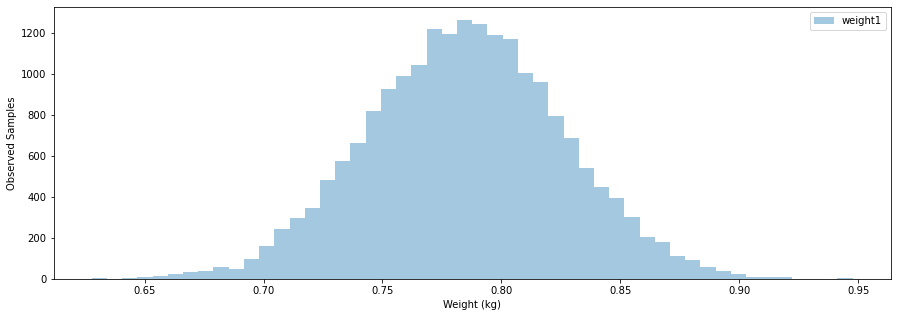

In [9]:
plt.figure(figsize=(15, 5))
sns.distplot(my_mcmc.get_samples()['weight1'].numpy(), kde=False, label="weight1")
plt.legend()
plt.xlabel("Weight (kg)")
plt.ylabel("Observed Samples")
plt.show()

We can also plot the summary and see what is the median value of this distribution to find the most likely value, as well as a 90% credibility interval. 

In [10]:
my_mcmc.summary(prob=0.9)


                mean       std    median      5.0%     95.0%     n_eff     r_hat
   weight1      0.78      0.04      0.79      0.72      0.85  29855.87      1.00

Number of divergences: 0


So we see the median value is about 0.79kg, and we're 90% confident the value for the weight of the item is between 0.72kg - 0.85kg (this is also room for us to judge if we're happy with that 90% range). 

You might now say "Well, you had a pretty good prior, your mean was very close to the true value of 0.8kg. What if you had used a less informative prior?"

Let's explore that scenario as well. This time we'll use a uniform distribution between 0.0 (the weight can't be negative), and 2kg (seems like a good upper threshold).

In [11]:
def model(observations):
    
    # 1. Let's define a prior distribution on the likely values of our weight.
    weight_prior = pyrodist.Uniform(0.0, 2.0)
    
    # 2. Sample a value from the weight distributoin
    weight = pyro.sample("weight2", weight_prior)
    
    # 3. Now use a that value to define our scale (remember our scale gives us values
    # from Normal(weight, 0.1))
    my_dist = pyrodist.Normal(weight, 0.1)
    
    
    # 4. For each of the observations, let's draw a sample from our distribution.
    # HOWEVER, this is an observed sample, it's a sample that should be in line with
    # the observations we have
    
    for i,observation in enumerate(observations):
        measurement = pyro.sample(f'obs_{i}', my_dist, obs=observation)

In [12]:
my_kernel = HMC(model)

my_mcmc2 = MCMC(my_kernel,
                num_samples=20000,
                warmup_steps=100)

my_mcmc2.run(observations)

Sample: 100%|██████████| 20100/20100 [03:14, 103.25it/s, step size=8.57e-01, acc. prob=0.978]


In [13]:
my_mcmc2.summary(prob=0.9)


                mean       std    median      5.0%     95.0%     n_eff     r_hat
   weight2      0.78      0.04      0.78      0.72      0.85   1059.35      1.00

Number of divergences: 0


Having this less informative prior did not make much of a difference. The algorithm is 90% confident the weight lies between 0.72kg and 0.85kg, and the mean of those values is again centered at 0.79kg (very close 0.8kg which was used).

We can grab the samples for this new approximation again, convert them to a NumPy array again, and plot the results as a distribution. You will see the distributions overlap very strongly, even though two very different priors were used.

In [14]:
my_mcmc2.get_samples()['weight2'].numpy()

array([0.78903055, 0.8146576 , 0.8092066 , ..., 0.79436463, 0.797696  ,
       0.81588846], dtype=float32)

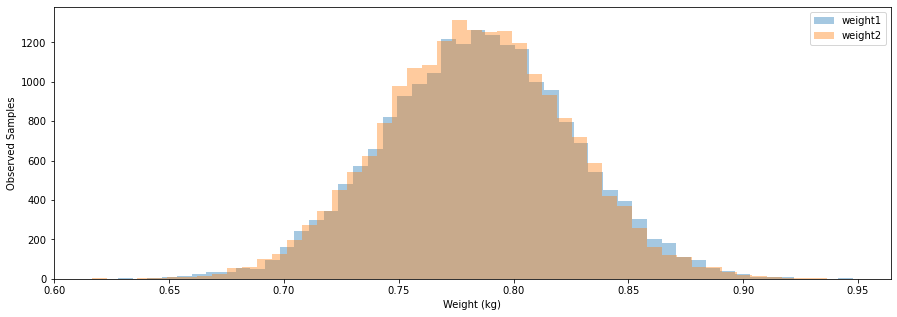

In [15]:
plt.figure(figsize=(15, 5))
sns.distplot(my_mcmc.get_samples()['weight1'].numpy(), kde=False, label="weight1")
sns.distplot(my_mcmc2.get_samples()['weight2'].numpy(), kde=False, label="weight2")
plt.legend()
plt.xlabel("Weight (kg)")
plt.ylabel("Observed Samples")
plt.show()

## Approximating Our Weight using Stochastic Variational Inference

You may notice that drawing all the samples using an MCMC method takes quite a bit of time. Pyro offers an alternative method of evaluating our hidden parameters that is faster, and can provide equally good results for some problems: Stochastic Variational Inference (SVI).

SVI methods treat this inference problem as an optimization one. Under the SVI method, we choose another distribution which is defined by some parameters (for example, the normal distribution is defined by its mean and standard deviation), and we optimize those parameters until our chosen distribution provides results which are "close enough" to our observations. 

This alternative method of evaluating a posterior requires an additional function, which is called a guide. This function defines our parameters, as well as our proposed distribution to match the observations.

Let's define our model again:

In [16]:
def model(observations):
    
    weight_prior = pyrodist.Uniform(0.0, 2.0)
    
    weight = pyro.sample("weight3", weight_prior)
    
    my_dist = pyrodist.Normal(weight, 0.1)
    
    
    for i,observation in enumerate(observations):
        measurement = pyro.sample(f'obs_{i}', my_dist, obs=observation)

And now, let's define our guide function:

In [17]:
from torch.distributions import constraints

def guide(observations):
    # 1. The guide must take exactly the same parameters as the model
    # even if it does not use them
    
    # 2. Our intial guesses for the mean and standard deviation
    # Let's guess that the mean is 0.0, and the standard deviation
    # is 1.0
    mean_parameter = pyro.param("mu", torch.tensor(0.0))
    std_parameter = pyro.param("sigma", torch.tensor(1.0), constraint=constraints.positive)
    
    # 3. Define the weight distribution these parameters define
    # We choose a normal distribution
    weight_distribution = pyrodist.Normal(mean_parameter, std_parameter)
    
    # 4. Every pyro.sample statement in the model
    # must have a matching pyro.sample statement
    # in the guide
    weight = pyro.sample("weight3", weight_distribution)

First, the guide and the model functions must accept the same inputs, even if the guide doesn't use any of them at all.

At (2) and (3) we say take a normal distribution, and adjust its parameters (the mean and standard deviation) so that it is more likely to produce the observed observation. In (2) we have to provide initial guesses for those parameters (notice the `pyro.param` statement, which is different than the `pyro.sample` in that it registers a parameter, not a distribution).

At (4) we draw a weight from the distribution we defined in (3). We don't actually have to store that value into a python variable, we only need the `pyro.sample` statement which is named exactly the same as it is in the model function. This is only the case for unobserved samples (those that don't have the `obs=` additional argument)

Now this becomes an optimization problem, we simply need to optimize `"mu"` and `"sigma"` such that the normal distribution defined by them is closer to producing our observed values.

In [18]:
# Import more fun items
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import ClippedAdam

# Clear all the parameter store
pyro.clear_param_store()

# Define our SVI algorithm. It accepts our model
# our guide, an optimizer, and a loss function
# to minimize
my_svi = SVI(model=model,
             guide=guide,
             optim=ClippedAdam({"lr": 0.001}),
             loss=Trace_ELBO())

# Decide on the number of optimization steps to 
# take, and run the optimizer for that
# many steps.

# We sent the parameters into model and guide
# in the .step() function

start_time = time.time()
optimization_steps = 10000
for i in range(optimization_steps):
    
    loss = my_svi.step(observations)
    
    if (i % 100 == 0):
        print(f'iter: {i}, loss: {round(loss,2)}', end="\r")

/Users/distiller/project/conda/conda-bld/pytorch_1591914893314/work/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha)


After performing the optimization, we can ask pyro for the found values of `"mu"` and `"sigma"`

In [19]:
print(f'"mu" is {pyro.param("mu")}')
print(f'"sigma" is {pyro.param("sigma")}')

"mu" is 0.7845805883407593
"sigma" is 0.040342673659324646


We can also ask for the same statistics as before about "weight3", such as the 90% credibility interval, but we have to do a bit more work for this.

We need to use our found values to generate new samples (MCMC works by generating samples, so we don't need that extra step after the algorithm runs then):

In [20]:
from pyro.infer import Predictive

sample_num = 20000
predictive = Predictive(model=model, 
                        guide=guide,
                        num_samples=sample_num,
                        return_sites=("weight3",)) # Notice this is a tuple

samples = predictive(observations)


stats = {}
for key, values in samples.items():

    stats = {"weight_mean": torch.mean(values, axis=0).detach().numpy(),
             "weight_5%": values.kthvalue(int(sample_num*0.05), axis=0)[0].detach().numpy(),
             "weight_95%": values.kthvalue(int(sample_num*0.95), axis=0)[0].detach().numpy()}
stats = pd.DataFrame(stats, index=[0])

In [21]:
print(stats)
end_time = time.time()
run_time_svi = round(end_time - start_time, 2)
print(f'Run time for SVI algorithm and result extraction: {run_time_svi} seconds')

   weight_mean  weight_5%  weight_95%
0     0.784121   0.717712    0.850685
Run time for SVI algorithm and result extraction: 18.94 seconds


We can see we are getting very similar results to those we observed when employing an MCMC model, but at a fraction of the run time. 

SVI approaches are designed to perform faster. However, since they require a pre-defined distribution as the guide, they can be difficult to choose for some distributions (e.g. multimodal). 
For distributions that can be approximated by pre-defined distributions, they are ideal since they offer a substantial performance boost.

We can also compare the resulting distribution we obtained by sampling from the SVI algorithm against our previous samples

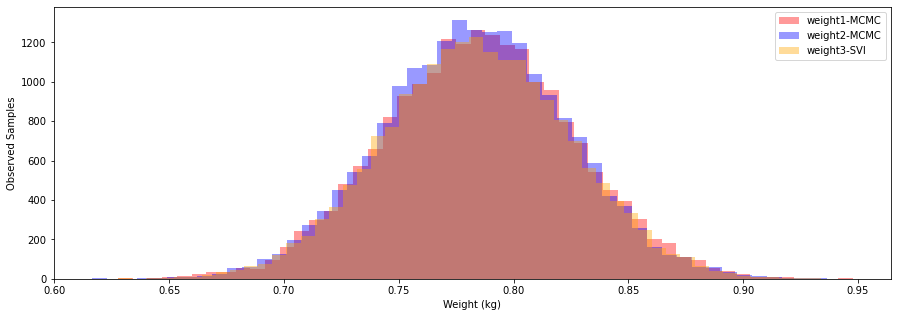

In [22]:
plt.figure(figsize=(15, 5))
sns.distplot(my_mcmc.get_samples()['weight1'].numpy(), kde=False, label="weight1-MCMC", color="red")
sns.distplot(my_mcmc2.get_samples()['weight2'].numpy(), kde=False, label="weight2-MCMC", color="blue")
sns.distplot(samples['weight3'].detach().numpy(), kde=False, label="weight3-SVI", color="orange")
plt.legend()
plt.xlabel("Weight (kg)")
plt.ylabel("Observed Samples")
plt.show()

## Employing an Autoguide

One final functionality I would like to introduce here is the use of autoguides in Pyro. 
Pyro offers the ability to employ pre-built auto-guide functions, when constructing your own guide can be a laborious task.

In [23]:
from pyro.infer.autoguide import AutoDiagonalNormal

# Redefine the model
def model(observations):
    
    # For autguides, the choice of prior
    # should be close in family and shape
    # to the guess we'd like to employ
    # Here, I chose my prior to be normal
    weight_prior = pyrodist.Normal(0.0, 1.0)
    
    weight = pyro.sample("weight4", weight_prior)
    
    my_dist = pyrodist.Normal(weight, 0.1)
    
    
    for i,observation in enumerate(observations):
        measurement = pyro.sample(f'obs_{i}', my_dist, obs=observation)
        
# Create a new SVI instance, this time with a
# pre-defined autoguide which takes
# the model function as an argument
my_autoguide = AutoDiagonalNormal(model, init_scale=1.0)

pyro.clear_param_store()
my_svi = SVI(model=model,
             guide=my_autoguide,
             optim=ClippedAdam({"lr": 0.001}),
             loss=Trace_ELBO())

# Optimize
print("Optimizing...")
start_time = time.time()
optimization_steps = 10000
for i in range(optimization_steps):
    
    loss = my_svi.step(observations)
    
    if (i % 100 == 0):
        print(f'iter: {i}, loss: {round(loss,2)}', end="\r")
print()

print("Parameters:")
print(f'"mu" is {pyro.param(my_autoguide._pyro_name+".loc").detach().numpy()}')
print(f'"sigma" is {pyro.param(my_autoguide._pyro_name+".scale").detach().numpy()}')

# Produce samples using the obtained process
print("Predicting...")
sample_num = 20000
predictive = Predictive(model=model, 
                        guide=my_autoguide,
                        num_samples=sample_num,
                        return_sites=("weight4",))

samples2 = predictive(observations)

# Find the mean and 90% credibility interval of the samples
stats = {}
for key, values in samples2.items():

    stats = {"weight_mean": torch.mean(values, axis=0).detach().numpy(),
             "weight_5%": values.kthvalue(int(sample_num*0.05), axis=0)[0].detach().numpy(),
             "weight_95%": values.kthvalue(int(sample_num*0.95), axis=0)[0].detach().numpy()}
stats = pd.DataFrame(stats, index=[0])
print(stats)
end_time = time.time()


run_time_svi = round(end_time - start_time, 2)
print(f'Run time for SVI algorithm and result extraction: {run_time_svi} seconds')

Optimizing...
iter: 9900, loss: -1.88
Parameters:
"mu" is [0.77290195]
"sigma" is [0.04055462]
Predicting...
   weight_mean  weight_5%  weight_95%
0     0.773199   0.706324      0.8403
Run time for SVI algorithm and result extraction: 23.17 seconds


We can also plot these results and compare the distributions of the two SVI approaches:

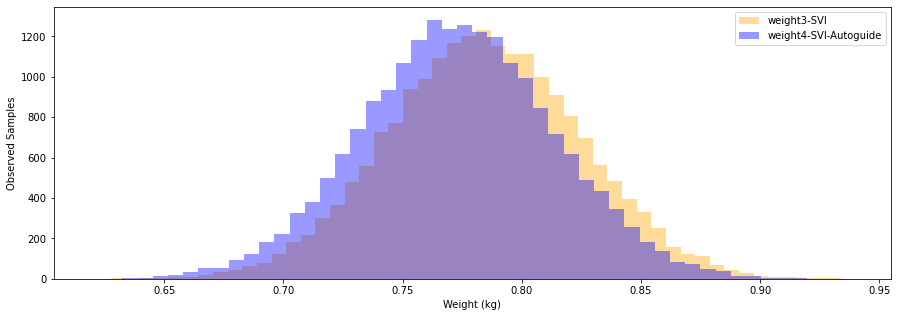

In [24]:
plt.figure(figsize=(15, 5))
sns.distplot(samples['weight3'].detach().numpy(), kde=False, label="weight3-SVI", color="orange")
sns.distplot(samples2['weight4'].detach().numpy(), kde=False, label="weight4-SVI-Autoguide", color="blue")
plt.legend()
plt.xlabel("Weight (kg)")
plt.ylabel("Observed Samples")
plt.show()

This tutorial showcases the basic functionality Pyro offers in performing inference about hidden parameter values in a model. 

I encourage everyone to explore [this talk by Zach Anglin](https://www.youtube.com/watch?v=5f-9xCuyZh4) for a discussion on probabilistic programming applications (the talk is shown using PyMC3, but should be easier to translate to Pyro now), as well as [this talk by Chi Nhan Nguyen](https://www.youtube.com/watch?v=mtFBfOmdFQk) which showcases how to employ Pyro to introduce uncertainty for overconfident neural networks (the talk uses an older version of Pyro).

In future tutorials, I will explore how to employ Pyro for more realistic applications, but when starting with any new library, an easy example which is easy to grasp can be incredibly instrumental in deciphering how the library works.